In [1]:
# Adding tigernlp
# !pip install --upgrade "C:\\Users\\akshta.choudhary\\Desktop\\NLP\\Case Study\\NLP_L2\\tigernlp-2.2.1-py3-none-any.whl" --user

In [2]:
# Importing the libraries
import os,re, nltk, spacy
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import contractions
from tigernlp.text_processing.api import TextProcessor
from tigernlp.absa.api import absa_training, predict_aspect_polarity, get_sample_config, get_ATEPC_modellist, data_preparation
from tigernlp.core.api import convert_df_column_list_values_to_rows

No CUDA GPU found in your device
Version 0.8.7.4 of metric_visualizer is outdated. Version 0.9.7 was released Wednesday April 12, 2023.
Version 1.16.25 of pyabsa is outdated. Version 2.3.1 was released Saturday April 15, 2023.
check release notes at https://github.com/yangheng95/PyABSA/blob/release/release-note.json


In [3]:
# If you dont have en_core_web_sm please uncomment the below
from spacy.cli import download
download('en_core_web_sm')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
# Getting the current directory
path = os.path.dirname(os.getcwd())
# Data path
data_path = os.path.join(path,"Dataset\\sub case study1")
# Checkpoint path
checkpoint_path = os.path.join(path,"Notebooks\\.ipynb_checkpoints\\checkpoints1")
# Raw Input data file name
input_data_file_name = "client C customer reviews.csv"
# Clean Input data file name
clean_input_data_file_name = "case1_cleaned_set.csv"

In [5]:
# Reading the raw data
raw_data_df = pd.read_csv(os.path.join(data_path,input_data_file_name))
raw_data_df.head()

Unnamed: 0  index                                          unique_id  \
0           0      0  Grocery & Gourmet Food_Beverages_Bottled Bever...   
1           2      2  Grocery & Gourmet Food_Beverages_Bottled Bever...   
2           3      3  Grocery & Gourmet Food_Beverages_Bottled Bever...   
3           5      5  Grocery & Gourmet Food_Beverages_Bottled Bever...   
4           6      6  Grocery & Gourmet Food_Beverages_Bottled Bever...   

                                          reviewText  \
0  ONE OF THE HARDEST THINGS ABOUT LOW CARBING IT...   
1  This is as good as it gets for a point margari...   
2  The strawberry margarita is all I have been ab...   
3  or they tasted just awful . I tried the origin...   
4  I then went a little nuts and ordered of just ...   

                       aspect                sentiment  
0                     ['MIX']              ['Neutral']  
1         ['point margarita']             ['Positive']  
2        ['margarita' 'find']  ['Positive' 'Positive']  
3  ['original Margarita mix']             ['Positive']  
4                  ['flavor']             ['Positive']

In [6]:
# Reading the cleaned data
data_df = pd.read_csv(os.path.join(data_path,clean_input_data_file_name))
data_df.head()

Unnamed: 0.1  Unnamed: 0  index  \
0             0           0      0   
1             1           2      2   
2             2           3      3   
3             3           5      5   
4             4           6      6   

                                           unique_id  \
0  Grocery & Gourmet Food_Beverages_Bottled Bever...   
1  Grocery & Gourmet Food_Beverages_Bottled Bever...   
2  Grocery & Gourmet Food_Beverages_Bottled Bever...   
3  Grocery & Gourmet Food_Beverages_Bottled Bever...   
4  Grocery & Gourmet Food_Beverages_Bottled Bever...   

                                          reviewText  \
0  ONE OF THE HARDEST THINGS ABOUT LOW CARBING IT...   
1  This is as good as it gets for a point margari...   
2  The strawberry margarita is all I have been ab...   
3  or they tasted just awful . I tried the origin...   
4  I then went a little nuts and ordered of just ...   

                       aspect                sentiment  num_of_sentiments  \
0                     ['MIX']              ['neutral']                  1   
1         ['point margarita']             ['positive']                  1   
2        ['margarita' 'find']  ['positive' 'positive']                  2   
3  ['original Margarita mix']             ['positive']                  1   
4                  ['flavor']             ['positive']                  1   

   num_of_aspects  is_negative  is_positive  is_neutral  \
0               1            0            0           1   
1               1            0            1           0   
2               2            0            1           0   
3               1            0            1           0   
4               1            0            1           0   

                          split_reviewText_sentences  number_of_sentences  \
0  ['ONE OF THE HARDEST THINGS ABOUT LOW CARBING ...                    4   
1  ['This is as good as it gets for a point marga...                    2   
2  ['The strawberry margarita is all I have been ...                    2   
3  ['or they tasted just awful .', 'I tried the o...                    2   
4  ['I then went a little nuts and ordered of jus...                    1   

   diff_between_num_sentences_num_sentiments            extracted_aspect  \
0                                          3                     ['MIX']   
1                                          1         ['point margarita']   
2                                          0          ['margarita find']   
3                                          1  ['original Margarita mix']   
4                                          0                  ['flavor']   

                                        cleaned_text  
0  one of the hard thing about low carbe it for I...  
1  this be as good as it get for a point margarit...  
2  the strawberry margarita be all I have be able...  
3  or they taste just awful I try the original ma...  
4  I then go a little nut and order of just about...

## Utility Functions

In [7]:
# Function to convert string list to list
def convert_stringlist_list(df,col_dict):
    for key,value in col_dict.items():
        df[value] = df[key].apply(lambda x : re.findall(r"'(.*?)'",x))
    return df

# Function to remove spaces
def remove_spaces(text):
    text=text.strip()
    text=text.split()
    return ' '.join(text)

# Function to see most common words
def most_common_words(df,num_words):
    # Counter for aspects
    top = Counter([item for item in df['extracted_aspect']])
    # Selecting the most common 100 words 
    temp_df = pd.DataFrame(top.most_common(num_words))
    # Renaming the columns
    temp_df.columns = ['Common_words','count']
    # Replacing anything not a word character with blank & spaces
    temp_df['Common_words'] = temp_df['Common_words'].map(lambda x: re.sub(r'\W+', '', x))
    temp_df['Common_words'] = temp_df['Common_words'].replace(r'\W+', '', regex=True)
    temp_df['Common_words'] = temp_df['Common_words'].apply(lambda x:remove_spaces(x))
    # Removing new line meaningless words
    temp_df=temp_df[~temp_df['Common_words'].isin(['s','gre','“',' * '])]
    # Mask to select the words
    mask1 = temp_df.Common_words.str.contains('[a-zA-Z]')
    mask2 = temp_df.Common_words.notna()
    temp_df = temp_df[mask1 | mask2]
    # Replacing whitespaces with nothing and nothing with NaN to drop them
    temp_df.Common_words =  temp_df.Common_words.str.replace(r"\s+", "").replace("", np.NaN)
    temp_df=temp_df.dropna()
    return temp_df

# Function to get most common words bar graph
def most_common_words_bar(df,num_words,title_text):
    df2 = most_common_words(df,num_words)
    # Creating a plot
    fig = px.bar(df2, x="count", y="Common_words", title=title_text, orientation='h', 
                 width=700, height=700,color='Common_words')
    fig.show()
    return

# Function to get most common words tree graph
def most_common_words_tree(df,num_words,title_text='Tree of Most Common Words'):
    df2 = most_common_words(df,num_words)
    # Creating a plot
    fig = px.treemap(df2, path=['Common_words'], values='count',title=title_text)
    fig.show()
    return

# Function to generate word cloud based on sentiment:
def word_cloud_sentiment(df):
    # Class object
    class SimpleGroupedColorFunc(object):
        def __init__(self, color_to_words, default_color):
            self.word_to_color = {word: color
                                  for (color, words) in color_to_words.items()
                                  for word in words}

            self.default_color = default_color

        def __call__(self, word, **kwargs):
            return self.word_to_color.get(word, self.default_color)
    # Converting all the aspects to lowercase
    df['extracted_aspect'] = df['extracted_aspect'].str.lower()
    # Getting the frequencies
    grouped_all_df = df[['extracted_aspect','extracted_sentiment']].groupby(['extracted_aspect','extracted_sentiment']).size().reset_index()
    # renaming the columns
    grouped_all_df.columns = ['word','score','freq']
    # Keeping the most frequent sentiment as final sentiment for that aspect
    grouped_df = grouped_all_df.groupby(['word'], as_index=False, sort=False).apply(lambda x: x.loc[x["freq"].idxmax()])
    # Generate a word-frequency dictionary to import to the word cloud
    text_freq_dict = dict(zip(grouped_df.word, grouped_df.freq))
    # Generate word cloud from word-frequency dictionary
    wordcloud = WordCloud(background_color='white',max_font_size = 50,collocations=False)
    wordcloud.generate_from_frequencies(frequencies=text_freq_dict)
    # List to store positive words
    pos_words = []
    # List to store negative words
    neg_words = []
    # Categorize the words based on sentiment score, assign to appropriate list 
    for word, sentiment in zip(grouped_df['word'], grouped_df['score']):
        if sentiment == 'positive':
            pos_words.append(word)
        elif sentiment == 'negative':
            neg_words.append(word)
    # Create a dictionary containing the colours to be used for each sentiment list Green for Positive and Red for Negative
    color_to_words = {'#00ff00': pos_words,'red': neg_words}
    # Neutral words will be grey (with sentiment between -1 and 1 inclusive)
    default_color = 'grey'
    # Create a color function with simple groupded tones
    grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
    # Apply our color function to the word cloud
    wordcloud.recolor(color_func=grouped_color_func)
    # Plot the word cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
# Function to get the Aspect length
def aspect_len(aspects):
    if len(aspects)==0:
        return 0
    else:
        return 1

## Data Checks & Pre-Processing

In [8]:
# Drop Columns 
data_df = data_df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'index','is_negative', 'is_positive', 'is_neutral','extracted_aspect'], axis=1)
# Checking the columns and null values
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129516 entries, 0 to 129515
Data columns (total 10 columns):
 #   Column                                     Non-Null Count   Dtype 
---  ------                                     --------------   ----- 
 0   unique_id                                  129516 non-null  object
 1   reviewText                                 129516 non-null  object
 2   aspect                                     129516 non-null  object
 3   sentiment                                  129516 non-null  object
 4   num_of_sentiments                          129516 non-null  int64 
 5   num_of_aspects                             129516 non-null  int64 
 6   split_reviewText_sentences                 129516 non-null  object
 7   number_of_sentences                        129516 non-null  int64 
 8   diff_between_num_sentences_num_sentiments  129516 non-null  int64 
 9   cleaned_text                               129516 non-null  object
dtypes: int64(4), object(

In [9]:
# Unique Aspects
len(data_df['aspect'].unique())

38548

In [10]:
# len of unique id's
len(data_df['unique_id'].unique())

68777

In [11]:
# Column dictionary to convert aspect and sentiment column to list
convert_col_dict = {"aspect":"extracted_aspect","sentiment":"extracted_sentiment"}
# Calling the function to convert the above columns
data_df1 = convert_stringlist_list(data_df,convert_col_dict)
# Exploding the dataframe to have 1 aspect every row
data_df2 = data_df1.apply(pd.Series.explode)
data_df2.head()

unique_id  \
0  Grocery & Gourmet Food_Beverages_Bottled Bever...   
1  Grocery & Gourmet Food_Beverages_Bottled Bever...   
2  Grocery & Gourmet Food_Beverages_Bottled Bever...   
2  Grocery & Gourmet Food_Beverages_Bottled Bever...   
3  Grocery & Gourmet Food_Beverages_Bottled Bever...   

                                          reviewText  \
0  ONE OF THE HARDEST THINGS ABOUT LOW CARBING IT...   
1  This is as good as it gets for a point margari...   
2  The strawberry margarita is all I have been ab...   
2  The strawberry margarita is all I have been ab...   
3  or they tasted just awful . I tried the origin...   

                       aspect                sentiment  num_of_sentiments  \
0                     ['MIX']              ['neutral']                  1   
1         ['point margarita']             ['positive']                  1   
2        ['margarita' 'find']  ['positive' 'positive']                  2   
2        ['margarita' 'find']  ['positive' 'positive']                  2   
3  ['original Margarita mix']             ['positive']                  1   

   num_of_aspects                         split_reviewText_sentences  \
0               1  ['ONE OF THE HARDEST THINGS ABOUT LOW CARBING ...   
1               1  ['This is as good as it gets for a point marga...   
2               2  ['The strawberry margarita is all I have been ...   
2               2  ['The strawberry margarita is all I have been ...   
3               1  ['or they tasted just awful .', 'I tried the o...   

   number_of_sentences  diff_between_num_sentences_num_sentiments  \
0                    4                                          3   
1                    2                                          1   
2                    2                                          0   
2                    2                                          0   
3                    2                                          1   

                                        cleaned_text        extracted_aspect  \
0  one of the hard thing about low carbe it for I...                     MIX   
1  this be as good as it get for a point margarit...         point margarita   
2  the strawberry margarita be all I have be able...               margarita   
2  the strawberry margarita be all I have be able...                    find   
3  or they taste just awful I try the original ma...  original Margarita mix   

  extracted_sentiment  
0             neutral  
1            positive  
2            positive  
2            positive  
3            positive

In [12]:
# Checking the columns and null values after the change
data_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174576 entries, 0 to 129515
Data columns (total 12 columns):
 #   Column                                     Non-Null Count   Dtype 
---  ------                                     --------------   ----- 
 0   unique_id                                  174576 non-null  object
 1   reviewText                                 174576 non-null  object
 2   aspect                                     174576 non-null  object
 3   sentiment                                  174576 non-null  object
 4   num_of_sentiments                          174576 non-null  int64 
 5   num_of_aspects                             174576 non-null  int64 
 6   split_reviewText_sentences                 174576 non-null  object
 7   number_of_sentences                        174576 non-null  int64 
 8   diff_between_num_sentences_num_sentiments  174576 non-null  int64 
 9   cleaned_text                               174576 non-null  object
 10  extracted_aspect    

In [13]:
# Unique Aspects
len(data_df2['extracted_aspect'].unique())

20358

In [14]:
# len of unique id's
len(data_df2['unique_id'].unique())

68777

In [15]:
# Checking how many aspects have more than 1 sentiment
count_df = data_df2.groupby(['extracted_aspect'])['extracted_sentiment'].nunique().reset_index()
count_df[count_df['extracted_sentiment']>1].head()

extracted_aspect  extracted_sentiment
0                            !                    2
21  & Chocolate - coated Fruit                    2
22   & Chocolate - coated Nuts                    2
24                           ,                    3
27                       , and                    2

## Exploratory Data Analysis

In [16]:
# Most common aspects based on counts
most_common_words_tree(data_df2,20)

C:\Users\akshta.choudhary\AppData\Local\Temp\ipykernel_21740\1401471984.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.Common_words =  temp_df.Common_words.str.replace(r"\s+", "").replace("", np.NaN)


C:\Users\akshta.choudhary\Anaconda3\envs\NLP\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



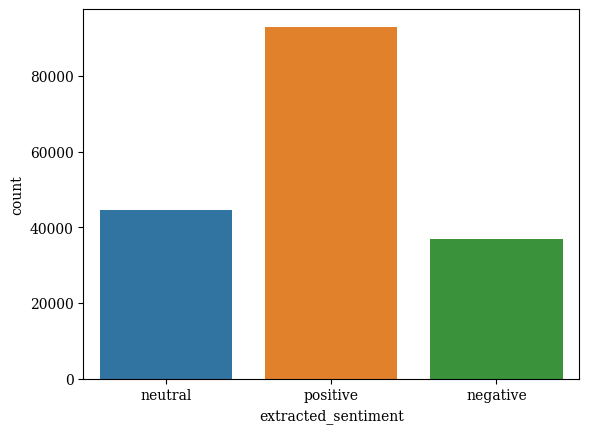

In [17]:
# Sentiment value counts
sns.countplot(x = "extracted_sentiment", data = data_df2)
plt.show()

In [18]:
# Positive sentiment aspects
positive_sentiment_df = data_df2[data_df2['extracted_sentiment']=='positive']
# Visualizing 10 most common words
most_common_words_bar(positive_sentiment_df,10,"Most Commmon Words in Positive Sentiment tweets")

C:\Users\akshta.choudhary\AppData\Local\Temp\ipykernel_21740\1401471984.py:32: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\akshta.choudhary\Anaconda3\envs\NLP\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [19]:
# Negative sentiment aspects
negative_sentiment_df = data_df2[data_df2['extracted_sentiment']=='negative']
# Visualizing 10 most common words
most_common_words_bar(negative_sentiment_df,10,"Most Commmon Words in Negative Sentiment tweets")

C:\Users\akshta.choudhary\AppData\Local\Temp\ipykernel_21740\1401471984.py:32: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\akshta.choudhary\Anaconda3\envs\NLP\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [20]:
# Neutral sentiment aspects
neutral_sentiment_df = data_df2[data_df2['extracted_sentiment']=='neutral']
# Visualizing 10 most common words
most_common_words_bar(negative_sentiment_df,10,"Most Commmon Words in Neutral Sentiment tweets")

C:\Users\akshta.choudhary\AppData\Local\Temp\ipykernel_21740\1401471984.py:32: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\akshta.choudhary\Anaconda3\envs\NLP\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



C:\Users\akshta.choudhary\AppData\Roaming\Python\Python39\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\akshta.choudhary\AppData\Roaming\Python\Python39\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\akshta.choudhary\AppData\Roaming\Python\Python39\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\akshta.choudhary\AppData\Roaming\Python\Python39\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\akshta.choudhary\AppData\Roaming\Python\Python39\site-packages\wordcloud\wordcl

C:\Users\akshta.choudhary\AppData\Roaming\Python\Python39\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\akshta.choudhary\AppData\Roaming\Python\Python39\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\akshta.choudhary\AppData\Roaming\Python\Python39\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\akshta.choudhary\AppData\Roaming\Python\Python39\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

C:\Users\akshta.choudhary\AppData\Roaming\Python\Python39\site-packages\wordcloud\wordcl

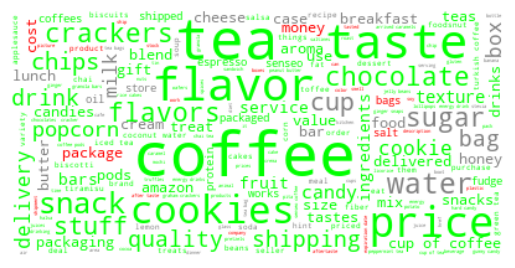

In [21]:
# Word cloud
word_cloud_sentiment(data_df2)

In [22]:
#spacy.load('en_core_web_lg')

## Modeling - TigerNLP

In [23]:
df1 = data_df1[["cleaned_text", "extracted_aspect", "extracted_sentiment"]]
df1.columns = ['sentence','aspect','sentiment']
df1["aspect_identifier"] = df1["aspect"].apply(aspect_len)
df1 = df1[df1["aspect_identifier"]==1]
df1.head()

C:\Users\akshta.choudhary\AppData\Local\Temp\ipykernel_21740\2520162593.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



sentence  \
0  one of the hard thing about low carbe it for I...   
1  this be as good as it get for a point margarit...   
2  the strawberry margarita be all I have be able...   
3  or they taste just awful I try the original ma...   
4  I then go a little nut and order of just about...   

                     aspect             sentiment  aspect_identifier  
0                     [MIX]             [neutral]                  1  
1         [point margarita]            [positive]                  1  
2         [margarita, find]  [positive, positive]                  1  
3  [original Margarita mix]            [positive]                  1  
4                  [flavor]            [positive]                  1

In [24]:
sentiments = []
for s in df1["sentiment"]:
    sentiments.extend(s)
set(sentiments)

{'negative', 'neutral', 'positive'}

In [25]:
list(df1["aspect"])[1]

['point margarita']

In [26]:
# Converting the sentiment to same format
#df1["sentiment"] = df1["sentiment"].apply(lambda x: x.title())
# Converting column list to rows using in-built function
df2 = convert_df_column_list_values_to_rows(df1, ["aspect", "sentiment"])
df2

sentence  aspect_identifier  \
0       one of the hard thing about low carbe it for I...                  1   
1       this be as good as it get for a point margarit...                  1   
2       the strawberry margarita be all I have be able...                  1   
3       the strawberry margarita be all I have be able...                  1   
4       or they taste just awful I try the original ma...                  1   
...                                                   ...                ...   
174571    snack pie be just like I remember when I be kid                  1   
174572    snack pie be great I buy snack pie where I live                  1   
174573  I buy one of snack pie individually today at a...                  1   
174574  snack pie be extremely small and do not taste ...                  1   
174575  just as yummy as I remember snack pie be as a ...                  1   

                        aspect sentiment  
0                          MIX   neutral  
1              point margarita  positive  
2                    margarita  positive  
3                         find  positive  
4       original Margarita mix  positive  
...                        ...       ...  
174571              Snack Pies  positive  
174572              Snack Pies  positive  
174573              Snack Pies   neutral  
174574              Snack Pies  negative  
174575              Snack Pies  positive  

[174576 rows x 4 columns]

In [27]:
df2.sentiment.value_counts()

positive    92906
neutral     44673
negative    36997
Name: sentiment, dtype: int64

In [ ]:
dataset_path = data_preparation(df2, path=data_path)

Load aspect extractor from checkpoints\ATEPC_ENGLISH_CHECKPOINT
config: checkpoints\ATEPC_ENGLISH_CHECKPOINT\fast_lcf_atepc.config
state_dict: checkpoints\ATEPC_ENGLISH_CHECKPOINT\fast_lcf_atepc.state_dict
model: None
tokenizer: checkpoints\ATEPC_ENGLISH_CHECKPOINT\fast_lcf_atepc.tokenizer


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have b

The results of aspect term extraction have been saved in C:\Users\akshta.choudhary\Desktop\NLP\Case Study\NLP_L2\Notebooks\atepc_inference.result.json


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Example 16051: be able to have freshly grind <coffee:Positive Confidence:0.9996527433395386> every morning have make get ready for work a whole lot easy ! sent ! positive
Example 16052: at that point I start a chat with an <amazon:Positive Confidence:0.7967512011528015> person who be very nice and they tell I just to return this too ! sent ! positive
Example 16053: plus a good thing about <mochi:Positive Confidence:0.9982113838195801> be that it be still make of more simple carb than refine so even though you do not want to eat a ton mochi be still a tiny bit well for you than a brownie or cookie ! sent ! positive
Example 16054: over half the <mini cup:Negative Confidence:0.9998348951339722> go foul less than half way to the expiration date so <cost:Negative Confidence:0.9997950196266174> be effectively more than double the competitor liquid creamer ! sent ! negative
Example 16055: just receive my second order of this product and grandma still can not count only cookie in a co package 

100%|████████████████████████████████████████████| 178/178 [2:06:35<00:00, 42.67s/it, classifying aspect sentiments...]


The results of aspect term extraction have been saved in C:\Users\akshta.choudhary\Desktop\NLP\Case Study\NLP_L2\Notebooks\atepc_inference.result.json
Example 0: the pre measure package be perfect for a nice <cup:Positive Confidence:0.9996811151504517> pot $ T $ though
Example 1: of coffee
Example 2: positive
Example 3: this item be sell as a $ T $ of <bag:Neutral Confidence:0.9992641806602478> in each pack I receive only four pack of the <tea:Positive Confidence:0.9990946054458618> be delicious and deserve five star
Example 4: six pack
Example 5: neutral
Example 6: thank you it be a $ T $ for a friend she be happy thank you
Example 7: gift
Example 8: positive
Example 9: but next time I order this $ T $ I be also go to get the one with the <pump:Positive Confidence:0.854043185710907> I highly recommend this $ T $
Example 10: peppermint syrup
Example 11: positive
Example 12: I like strong flavored $ T $ but I find the douwe <dark roast:Negative Confidence:0.9996483325958252> too bitter 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 99%|██████████████████████████████████████████████▍| 1619/1637 [38:20:13<14:12, 47.33s/it, extracting aspect terms...]

In [ ]:
atepc_config = get_sample_config()
atepc_config

In [ ]:
ATEPCModelList = get_ATEPC_modellist()
ATEPCModelList

In [ ]:
atepc_config.pretrained_bert = 'microsoft/deberta-v3-base'
# atepc_config.num_epoch = 2
# atepc_config.batch_size = 16
atepc_config.model = ATEPCModelList["FAST_LCF_ATEPC"]
atepc_config

In [ ]:
absa_training(dataset_path=dataset_path,path_to_save_checkpoints=checkpoint_path, 
              atepc_config=atepc_config, checkpoint='multilingual', auto_device=True)

In [ ]:
aspect_polarity_owntrained_df = predict_aspect_polarity(list(df3["sentence"])[:20], checkpoint=checkpoint_path)

In [ ]:
aspect_polarity_owntrained_df.head()